# **Fourier spectral solver for phase-field crystal model (Numpy)**
Total free energy
$$
G(\phi, \nabla \phi)=\int_V \left\{ \frac{1}{2}\phi \left[ \epsilon + \left(1+\nabla^2\right)^2 \right] \phi + \frac{1}{4}\phi^4 \right\}dV
$$
Cahn-Hilliard equation assuming $M$ is constant
$$
\frac{\partial \phi}{\partial t} = \nabla \cdot \left( M \nabla \frac{\delta G}{\delta \phi} \right) =  M\nabla^2 \mu
$$
Potential
$$
\mu = \frac{\delta G}{\delta \phi} = \epsilon \phi + \phi^3 + (1+2\nabla^2+\nabla^4)\phi 
$$
Cahn-Hilliard equation
$$
\frac{\partial \phi}{\partial t} =  \nabla^2 M \left\{ \epsilon \phi + \phi^3 + (1+2\nabla^2+\nabla^4)\phi \right\}
$$
Fourier transform
$$
\frac{\partial \hat \phi}{\partial t} =  -k^2 M \left\{ \epsilon \hat \phi + \hat\phi^3 + (1-2k^2+k^4)\hat\phi \right\}
$$
Semi-implicit time integration
$$
\frac{\hat \phi_{t+1}-\hat \phi_{t}}{\Delta t} =  -k^2 M \left\{ \epsilon \hat \phi_{t+1} + \hat\phi_t^3 + (1-2k^2+k^4)\hat\phi_{t+1} \right\}
$$

Concentration at time $t+1$
$$
\hat{\phi}_{t+1}=\frac{\hat\phi_{t}-\Delta t M k^2 \hat \phi_t^3}{1+\Delta t M  k^2\left(\epsilon+1-2k^2+k^4 \right)}
$$

Inverse Fourier transform 
$$
\phi_{t+1}=\mathcal{F}^{-1}(\hat \phi_{t+1})
$$

## **Import library**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

## **Define parameters**

In [2]:
nx = ny = 512
pi = 4.0*np.arctan(1.0)
dx = dy = pi/4.0
total_step =  5000
dt = 1.0e-2
mobility = 1.0
epsilon = -0.5 # temperature parameter
phi0 = -0.3   # average density
noise = phi0*0.05 

## **Define numpy arrays**

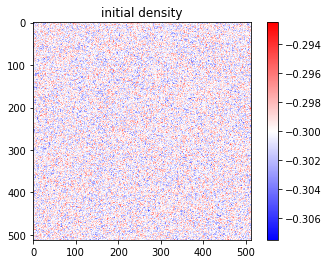

In [3]:
phi = np.zeros([nx, ny])
phi3 = np.zeros([nx, ny])

phi = phi0 + noise * (0.5 - np.random.rand(nx, ny))
plt.imshow(phi, cmap='bwr')
plt.title('initial density')
plt.colorbar()
plt.show() 

## **Define function to calculate Fourier ($k^2$) vector and calculate $k^4$**

In [4]:
def calc_wave_vector(nx, ny, dx, dy):
	nx21 = int(nx/2 + 1)
	ny21 = int(ny/2 + 1)
	nx2 = nx + 2
	ny2 = ny + 2
	dkx = (2.0 * np.pi) / (nx * dx)
	dky = (2.0 * np.pi) / (ny * dy)
	kx = np.zeros([nx, ny])
	ky = np.zeros([nx, ny])
	k2 = np.zeros([nx, ny])
	k4 = np.zeros([nx, ny])

	for i in range(1, nx21):
		for j in range(1, ny):
			fk1 = (i - 1) * dkx
			kx[i, :] = fk1
			kx[nx - i, :] = -fk1
	for i in range(1, nx):
		for j in range(1, ny21):
			fk2 = (j - 1) * dky
			ky[:, j] = fk2
			ky[:, ny - j] = -fk2

	k2[:, :] = kx[:, :]**2 + ky[:, :]**2
	return k2

k2 = calc_wave_vector(nx, ny, dx, dy)
k4 = k2 **2

## **Solve phase-field crystal model**

It takes  202787.3101234436 ms


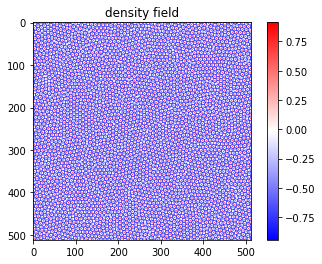

In [5]:
start = time()
for istep in range(1, total_step):
  phik = np.fft.fftn(phi)
  phi3 = phi**3
  phik3 = np.fft.fftn(phi3)
  nummer = dt * mobility * k2 * phik3
  denom = 1.0 + dt * mobility * k2 * (epsilon + 1.0 - 2.0*k2 + k4)
  phik = (phik - nummer) / denom
  phi = np.real(np.fft.ifftn(phik))

#  if istep % output_step == 0:
#    print('nstep = ', istep)
#    plt.imshow(phi, cmap='bwr')
#    plt.title('density field')
#    plt.colorbar()
#    plt.show() 

end = time()
print("It takes ", (end-start)*1000.0, "ms")

plt.imshow(phi, cmap='bwr')
plt.title('density field')
plt.colorbar()
plt.show() 